<a href="https://colab.research.google.com/github/fds787896/KagglePractice/blob/master/Crime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install matplotlib --upgrade


In [3]:
pip install geopandas

     |████████████████████████████████| 1.0 MB 9.4 MB/s 
     |████████████████████████████████| 16.7 MB 8.7 MB/s 
     |████████████████████████████████| 6.3 MB 45.9 MB/s 


In [4]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=7e87754c6fec3cd5ee54a9156994a2d9dd5ea28af9f8da4429c4a54b3f3b1d4e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [5]:
pip install catboost

     |████████████████████████████████| 76.6 MB 45 kB/s 


In [6]:
%cd /content/drive/MyDrive/SanFranciscoCrime/

/content/drive/MyDrive/SanFranciscoCrime


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from shapely.geometry import Point
import geopandas as gpd
import wget
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import pickle

In [114]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [115]:
#查看行數及特徵數量
train_rows, train_columns = train.shape
test_rows, test_columns = test.shape
print("Train data has {row}rows and {column}columns".format(row=str(train_rows),column=str(train_columns)))
print("Test data has {row}rows and {column}columns".format(row=str(test_rows),column=str(test_columns)))
#特徵數量似乎不一樣,需進一步資料探索

Train data has 101363rows and 9columns
Test data has 143578rows and 7columns


In [116]:
#查看資料型態
print(train.info(), test.info())
#看起來大部分都是類別型資料,date資料看起來尚未轉換。依據文檔所述,Descript以及Resolution只有train有

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101363 entries, 0 to 101362
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       101363 non-null  object 
 1   Category    101363 non-null  object 
 2   Descript    101363 non-null  object 
 3   DayOfWeek   101363 non-null  object 
 4   PdDistrict  101363 non-null  object 
 5   Resolution  101363 non-null  object 
 6   Address     101363 non-null  object 
 7   X           101363 non-null  float64
 8   Y           101362 non-null  float64
dtypes: float64(2), object(7)
memory usage: 7.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143578 entries, 0 to 143577
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Id          143578 non-null  int64  
 1   Dates       143577 non-null  object 
 2   DayOfWeek   143577 non-null  object 
 3   PdDistrict  143577 non-null  object 
 4   Address  

In [117]:
#查看前10行資料
train.head(10)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564
8,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,RICHMOND,NONE,600 Block of 47TH AV,-122.508194,37.776601
9,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,CENTRAL,NONE,JEFFERSON ST / LEAVENWORTH ST,-122.419088,37.807802


In [118]:
#把時間類型資料做轉換
train["Dates"] = pd.to_datetime(train["Dates"], format="%Y-%m-%d %H:%M:%S")
test["Dates"] = pd.to_datetime(test["Dates"], format="%Y-%m-%d %H:%M:%S")
train["Dates"].head(10)

0   2015-05-13 23:53:00
1   2015-05-13 23:53:00
2   2015-05-13 23:33:00
3   2015-05-13 23:30:00
4   2015-05-13 23:30:00
5   2015-05-13 23:30:00
6   2015-05-13 23:30:00
7   2015-05-13 23:30:00
8   2015-05-13 23:00:00
9   2015-05-13 23:00:00
Name: Dates, dtype: datetime64[ns]

In [119]:
#查看個特徵的值域(類別型資料)
train.describe(include=["O"])

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address
count,101363,101363,101363,101363,101363,101363
unique,37,701,7,10,16,14222
top,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST
freq,26203,10622,15459,19450,66456,2838


In [120]:
#查看缺失值
combine = pd.concat([train,test], axis=0, ignore_index=True)
combine.isnull().sum().sort_values(ascending=False)
#Descript及Resolution為train才有的特徵,Category為預測目標,這三者的缺失值與test的長度相同,所以合理,其他看起來並沒有什麼缺失的狀況

Category      143578
Descript      143578
Resolution    143578
Id            101363
Y                  2
Dates              1
DayOfWeek          1
PdDistrict         1
Address            1
X                  1
dtype: int64

In [121]:
#填補缺失值的方法填入該特徵的眾數,因為缺失的狀況沒有特別明顯
values = {"Y":combine["Y"].mode()[0],
      "Dates":combine["Dates"].mode()[0],
      "DayOfWeek":combine["DayOfWeek"].mode()[0],
      "PdDistrict":combine["PdDistrict"].mode()[0],
      "Address":combine["Address"].mode()[0],
      "X":combine["X"].mode()[0]}
combine = combine.fillna(value=values)

In [122]:
#查看NONE有多少個
for column in combine.select_dtypes(include=["O"]).columns:
  NoneNumber = len(combine[column][combine[column].str.contains("None", na=False, case=False)])
  print("{Column} has {Number} None".format(Column=column, Number=str(NoneNumber)))
#Resolution看起来缺失情况很多,佔比6成以上,可以直接將這個特徵drop

Category has 0 None
Descript has 0 None
DayOfWeek has 0 None
PdDistrict has 0 None
Resolution has 66456 None
Address has 0 None


In [123]:
#先把時間欄位拆解出更多特徵
combine["Year"] = pd.DatetimeIndex(combine["Dates"]).year
combine["Month"] = pd.DatetimeIndex(combine["Dates"]).month
combine["Day"] = pd.DatetimeIndex(combine["Dates"]).day
combine["Hour"] = pd.DatetimeIndex(combine["Dates"]).hour

In [124]:
#把填補好缺失值的combine分割為train及test
train = combine[~combine["Category"].isnull()].drop(columns=["Id","Resolution"])
test = combine[combine["Category"].isnull()].drop(columns=["Category","Descript","Resolution"])

In [125]:
#查看個特徵的值域(類別型資料)
train.describe(include=["O"])

,Category,Descript,DayOfWeek,PdDistrict,Address
count,101363,101363,101363,101363,101363
unique,37,701,7,10,14222
top,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,800 Block of BRYANT ST
freq,26203,10622,15459,19450,2838


In [126]:
#年度資料只有兩年,進一步確認其月分值是否都有完整12月。並創造一個新特徵YearOfMonth
print(train.groupby(["Year","Month"]).size())
train["YearOfMonth"] = train["Year"].astype(str)+train["Dates"].map(lambda x: datetime.strftime(x, "%m"))
test["YearOfMonth"] = test["Year"].astype(str)+test["Dates"].map(lambda x: datetime.strftime(x, "%m"))
np.sort(train["YearOfMonth"].unique())

Year  Month
2014  1        4793
      2        5659
      3        6240
      4        6549
      5        6759
      6        5992
      7        5808
      8        6147
      9        6667
      10       7303
      11       6471
      12       5391
2015  1        5866
      2        6008
      3        6851
      4        6609
      5        2250
dtype: int64


array(['201401', '201402', '201403', '201404', '201405', '201406',
       '201407', '201408', '201409', '201410', '201411', '201412',
       '201501', '201502', '201503', '201504', '201505'], dtype=object)

In [127]:
#查看重複值的部分(train及test需要分別查看)。
print("The train duplicated value has {number}".format(number=str(train.duplicated().sum())))
print("The test duplicated value has {number}".format(number=str(test.duplicated().sum())))

The train duplicated value has 278
The test duplicated value has 0


In [128]:
#移除重複值,只留下第一筆資料
train = train.drop_duplicates(keep="first")

[Text(0, 0, 'SOUTHERN'),
 Text(1, 0, 'MISSION'),
 Text(2, 0, 'NORTHERN'),
 Text(3, 0, 'CENTRAL'),
 Text(4, 0, 'BAYVIEW'),
 Text(5, 0, 'INGLESIDE'),
 Text(6, 0, 'TENDERLOIN'),
 Text(7, 0, 'TARAVAL'),
 Text(8, 0, 'PARK'),
 Text(9, 0, 'RICHMOND')]

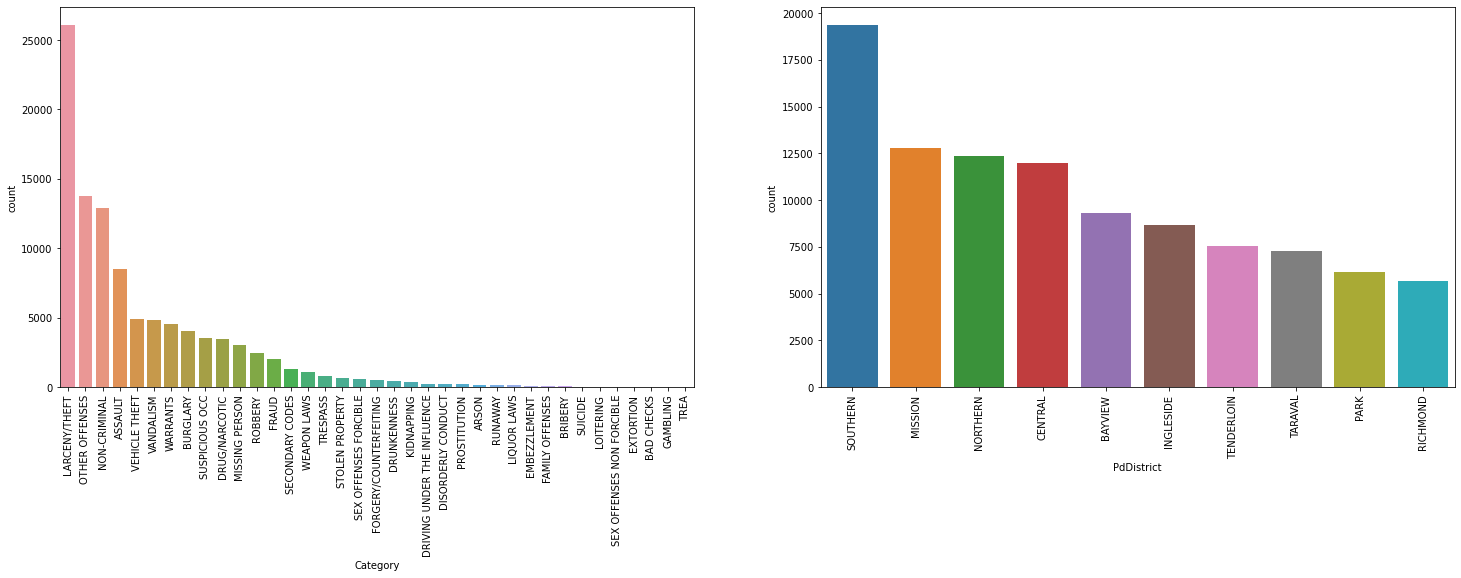

In [129]:
#單維度探索(Category,PdDistrict)
fig, axes = plt.subplots(1, 2, figsize=(25, 7))
Category = sns.countplot(x="Category", data=train, order=train["Category"].value_counts().index, ax=axes[0])
Category.set_xticklabels(Category.get_xticklabels(), rotation=90)

PdDistrict = sns.countplot(x="PdDistrict", data=train, order=train["PdDistrict"].value_counts().index, ax=axes[1])
PdDistrict.set_xticklabels(PdDistrict.get_xticklabels(), rotation=90)

[Text(0.5, 1.0, 'DayOfWeek'), Text(0.5, 0, '')]

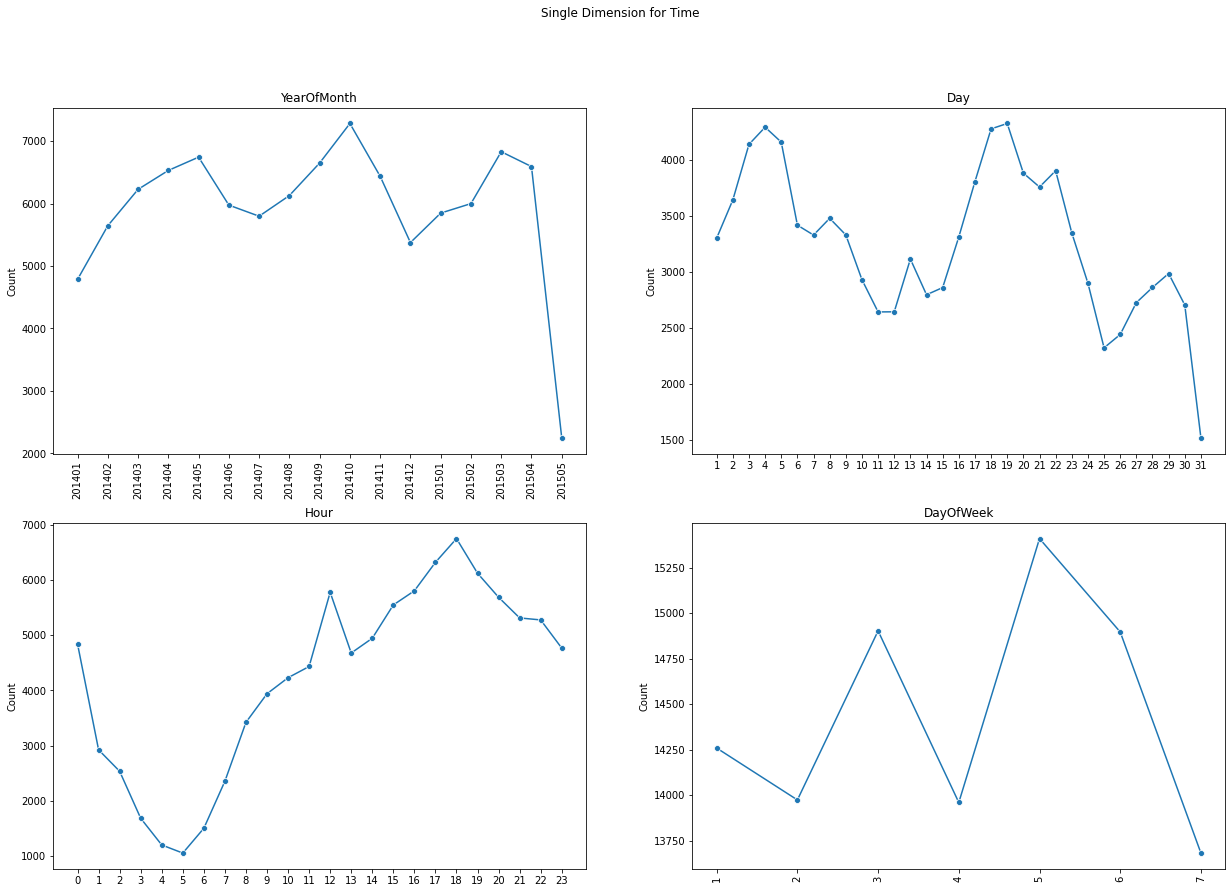

In [130]:
#單維度探索(時間)
fig, axes = plt.subplots(2, 2, figsize=(21, 14))
fig.suptitle("Single Dimension for Time")

YearMonthGroup = train.groupby("YearOfMonth").size().reset_index().rename(columns={0:"Count"})
Year = sns.lineplot(x="YearOfMonth", y="Count", data=YearMonthGroup, ax=axes[0,0], marker="o")
Year.set_xticks(range(len(YearMonthGroup)), labels=YearMonthGroup["YearOfMonth"].tolist(), rotation=90)
Year.set(title="YearOfMonth", xlabel=None)

DayGroup = train.groupby("Day").size().reset_index().rename(columns={0:"Count"}).astype("int").sort_values(by=["Day"])
Day = sns.lineplot(x="Day", y="Count", data=DayGroup, ax=axes[0,1], marker="o")
Day.set_xticks(range(1,len(DayGroup)+1), labels=DayGroup["Day"].astype(int).sort_values().tolist())
Day.set(title="Day", xlabel=None)

HourGroup = train.groupby("Hour").size().reset_index().rename(columns={0:"Count"}).astype("int").sort_values(by=["Hour"])
Hour = sns.lineplot(x="Hour", y="Count", data=HourGroup, ax=axes[1,0], marker="o")
Hour.set_xticks(range(len(HourGroup)), labels=HourGroup["Hour"].astype(int).sort_values().tolist())
Hour.set(title="Hour", xlabel=None)

DayOfWeekGroup = train.groupby("DayOfWeek").size().reset_index().rename(columns={0:"Count"})
dic = {}
for i,j in zip(DayOfWeekGroup["DayOfWeek"],[5,1,6,7,4,2,3]):
  dic[i]=j
DayOfWeekGroup["DayOfWeek"] = DayOfWeekGroup["DayOfWeek"].map(dic).astype(int)
DayOfWeekGroup.sort_values(by=["DayOfWeek"], inplace=True)
DayOfWeek = sns.lineplot(x="DayOfWeek", y="Count", data=DayOfWeekGroup, ax=axes[1,1], marker="o")
DayOfWeek.set_xticks(range(1,len(DayOfWeekGroup)+1), labels=DayOfWeekGroup["DayOfWeek"].astype(int).sort_values().tolist(), rotation=90)
DayOfWeek.set(title="DayOfWeek", xlabel=None)

In [131]:
#根據時間單維度觀察結果,做出一些小結,月份而言,冬季的數量似乎較高,以天來看月初及月中數量較高,以小時來看,中午及下午6-7點數量較高,以星期幾來看3及5數量較高
#所以可以依據這些觀察到的結果將我們的時間重新分組
SeasonDic = {"Spring":[2,3,4], "Summer":[5,6,7], "Autumn":[8,9,10], "Winter":[11,12,1]}

DayDic = {"1-5":list(range(1,6)), "6-10":list(range(6,11)), "11-15":list(range(11,16)), "16-20":list(range(16,21)), "21-25":list(range(21,26)), "26-31":list(range(26,32))}

HourDic = {"1-4":list(range(1,5)), "5-8":list(range(5,9)), "9-12":list(range(9,13)), "13-16":list(range(13,17)), "17-20":list(range(17,21)), "21-24":list(range(21,25))}

def ReGroup(olddic,newcol,oldcol):
  newdic = {}
  for key,value in olddic.items():
    for number in value:
      newdic[number] = key
  train[newcol] = train[oldcol].map(newdic)
  return train[newcol]

train["Season"] = ReGroup(SeasonDic,"Season","Month")
train["DayRange"] = ReGroup(DayDic,"DayRange","Day")
train["HourRange"] = ReGroup(HourDic,"HourRange","Hour")
test["Season"] = ReGroup(SeasonDic,"Season","Month")
test["DayRange"] = ReGroup(DayDic,"DayRange","Day")
test["HourRange"] = ReGroup(HourDic,"HourRange","Hour")

In [132]:
#雙維度分析
#因為預測目標種類太多,直接作圖顯得太雜亂,故把犯罪種類累計占比80%的項目抓出來做觀察,並且將Month,Day,Hour根據單維度觀察結果重新分類

CategoryGroup = train.groupby("Category").size().reset_index().rename(columns={0:"Count"}).sort_values(by=["Count"], ascending=False)
CategoryGroup["Proportion"] = CategoryGroup["Count"]/CategoryGroup["Count"].sum()
CategoryGroup["Cum_Percentage"] = 100*(CategoryGroup["Proportion"].cumsum() / CategoryGroup["Proportion"].sum())
# CategoryGroup["Category"][0:9].tolist()
#前九種犯罪占了82%,剩下28種占了18%

train80 = train[train["Category"].str.contains('|'.join(CategoryGroup["Category"][0:9].tolist()))]

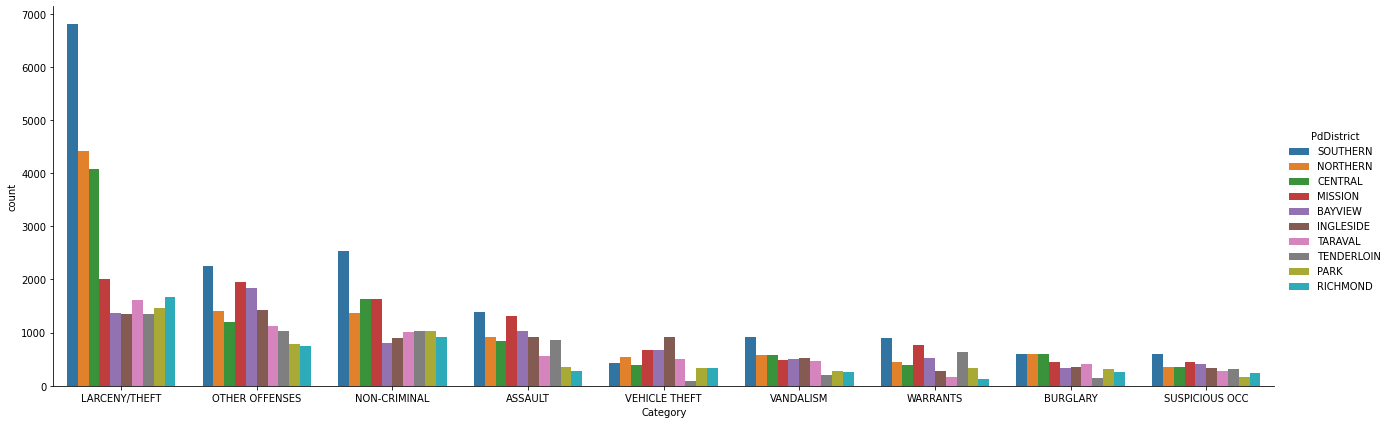

In [133]:
#雙維度探索(PdDistrict&Catgegory)
sns.catplot(x="Category", kind="count", hue="PdDistrict", data=train80, height=6, aspect=3, order=train80["Category"].value_counts().index, hue_order=train80["PdDistrict"].value_counts().index)
#除了Vehicle theft外,其他所有犯罪皆在南方發生比例最高

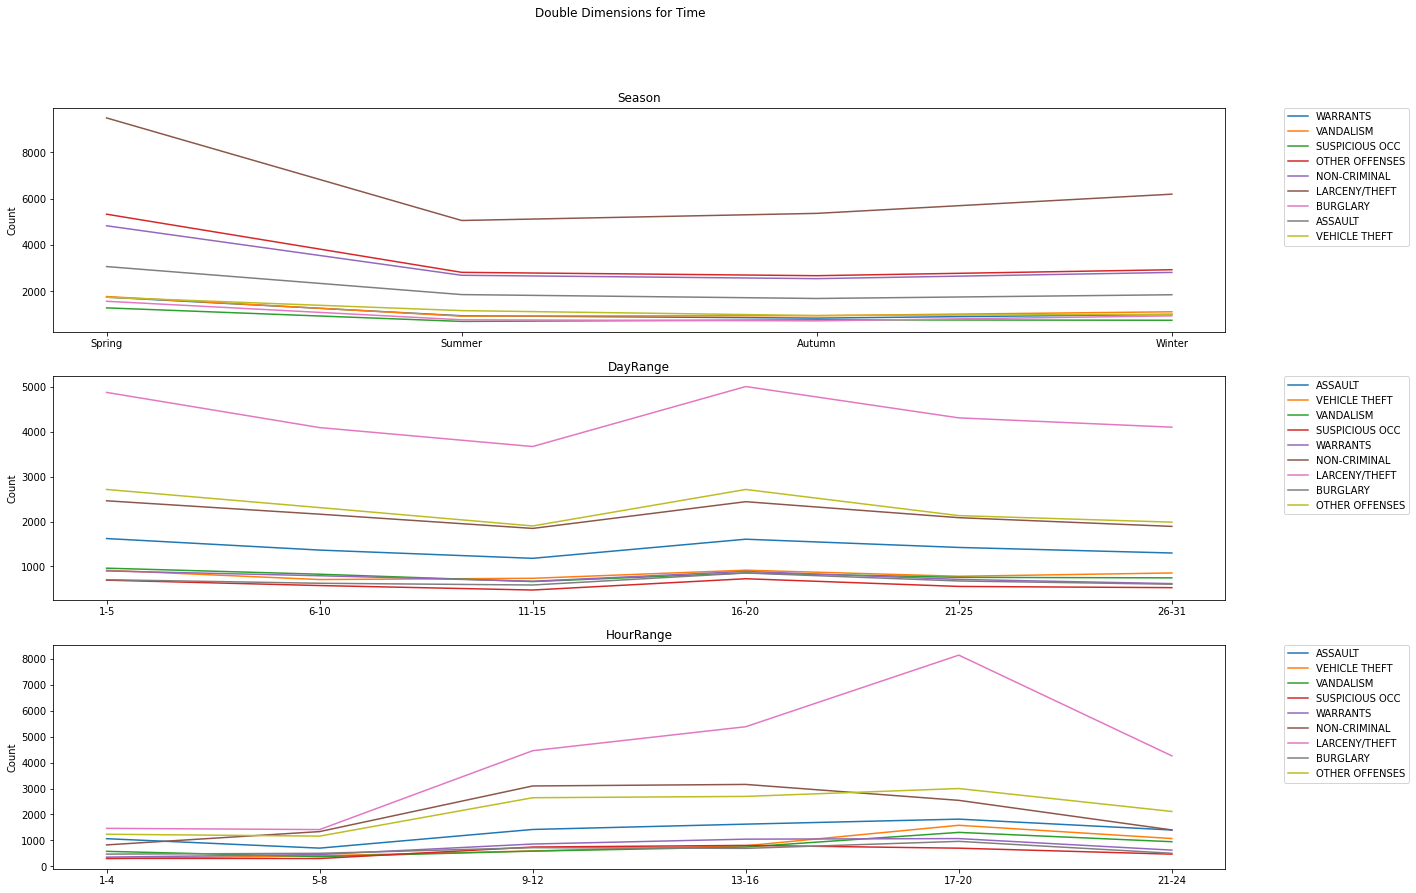

In [134]:
#雙維度探索(Season&Category, DayRange$Category, HourRange&Category)
fig, axes = plt.subplots(3, 1, figsize=(21, 14))
fig.suptitle("Double Dimensions for Time")

SeasonGroup = train80.groupby(["Season","Category"]).size().reset_index().rename(columns={0:"Count"})
SeasonGroup["Order"] = SeasonGroup["Season"].map({"Spring":1,"Summer":2,"Autumn":3,"Winter":4})
SeasonGroup = SeasonGroup.sort_values(by=["Order"])
Season = sns.lineplot(x="Season", y="Count", data=SeasonGroup, hue="Category", ax=axes[0], legend="brief")
Season.set(title="Season", xlabel=None)
Season.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

DayRangeGroup = train80.groupby(["DayRange","Category"]).size().reset_index().rename(columns={0:"Count"})
DayRangeGroup["Order"] = DayRangeGroup["DayRange"].map({"1-5":1,"6-10":2,"11-15":3,"16-20":4,"21-25":5,"26-31":6})
DayRangeGroup = DayRangeGroup.sort_values(by=["Order"])
DayRange = sns.lineplot(x="DayRange", y="Count", data=DayRangeGroup, hue="Category", ax=axes[1])
DayRange.set(title="DayRange", xlabel=None)
DayRange.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

HourRangeGroup = train80.groupby(["HourRange","Category"]).size().reset_index().rename(columns={0:"Count"})
HourRangeGroup["Order"] = HourRangeGroup["HourRange"].map({"1-4":1,"5-8":2,"9-12":3,"13-16":4,"17-20":5,"21-24":6})
HourRangeGroup = HourRangeGroup.sort_values(by=["Order"])
HourRange = sns.lineplot(x="HourRange", y="Count", data=HourRangeGroup, hue="Category", ax=axes[2])
HourRange.set(title="HourRange", xlabel=None)
HourRange.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

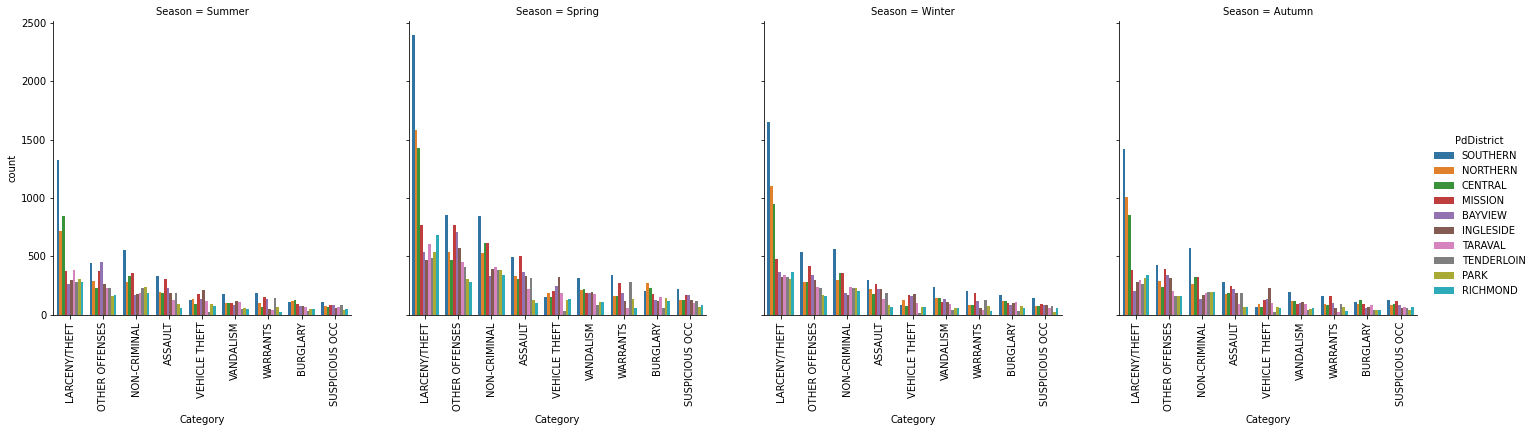

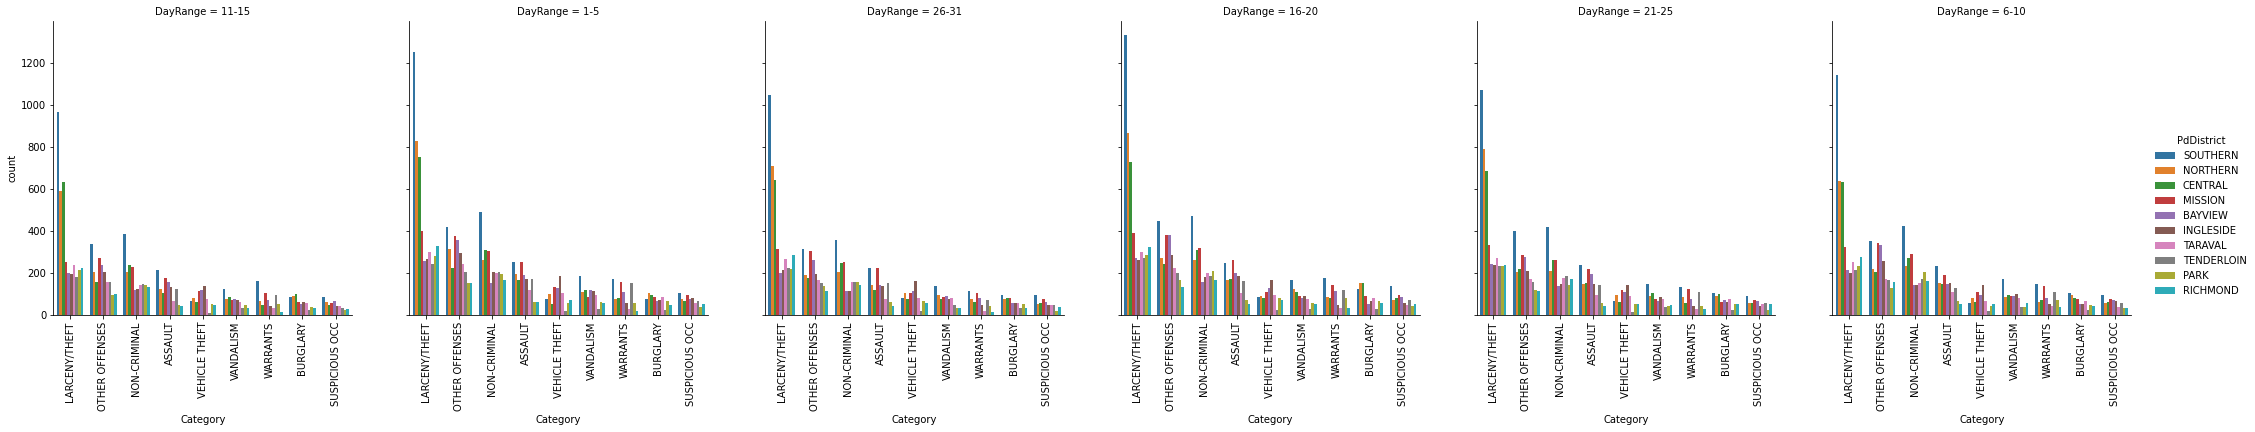

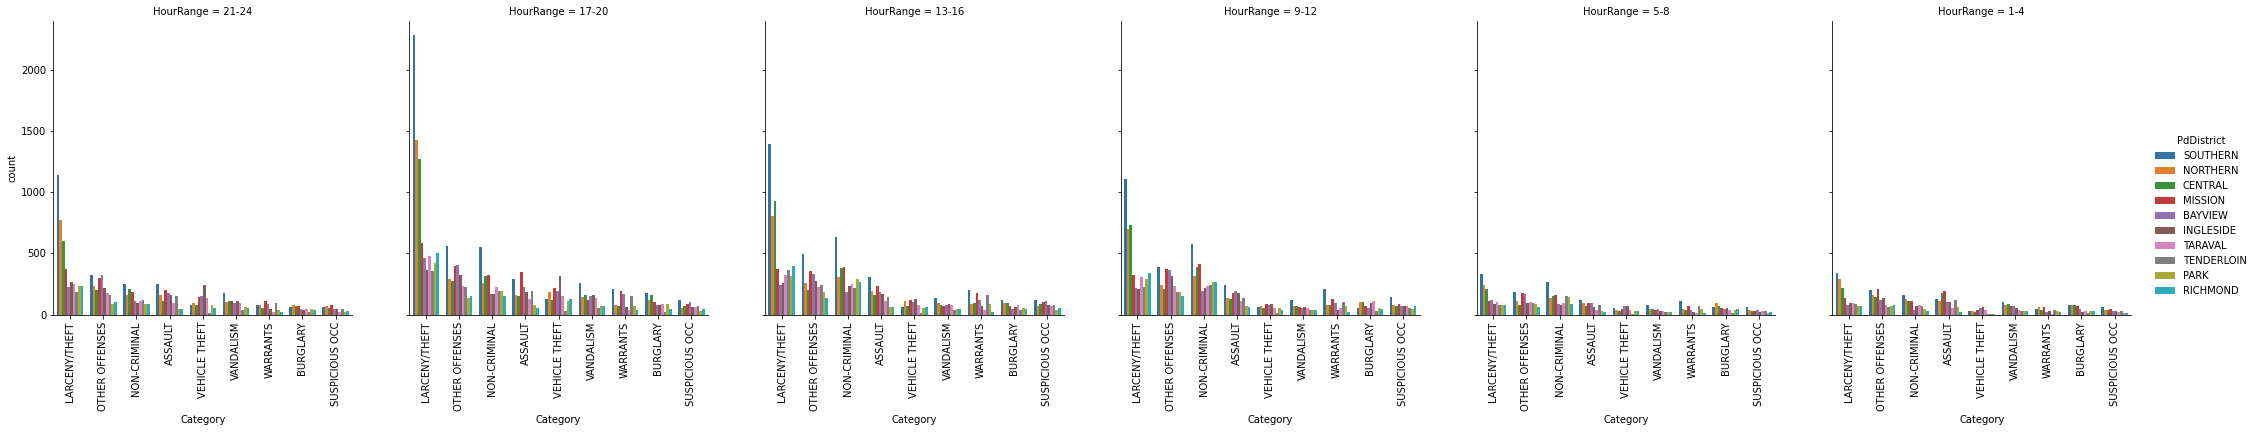

In [135]:
#三維度探索(一維及二維固定為Category及PdDistrict,第三個維度擺入不同時間點ex:Season,DayRange,HourRange)
Season = sns.catplot(x="Category", kind="count", hue="PdDistrict", col="Season", data=train80, order=train80["Category"].value_counts().index,hue_order=train80["PdDistrict"].value_counts().index )
Season.set_xticklabels(rotation=90)

DayRange = sns.catplot(x="Category", kind="count", hue="PdDistrict", col="DayRange", data=train80, order=train80["Category"].value_counts().index,hue_order=train80["PdDistrict"].value_counts().index)
DayRange.set_xticklabels(rotation=90)

HourRange = sns.catplot(x="Category", kind="count", hue="PdDistrict", col="HourRange", data=train80, order=train80["Category"].value_counts().index,hue_order=train80["PdDistrict"].value_counts().index)
HourRange.set_xticklabels(rotation=90)

In [136]:
#探索經緯度變亮,主要查看分布狀況以及有沒有一些點分布狀況不合理

In [137]:
#下載Sanfrancisco地圖,並讀取
# url = "https://ibm.box.com/public/static/9luw8hp6klzopv2p9zg11uy2y0fmzrr5.geojson"
# wget.download(url)
SanfranciscoMap = gpd.read_file("san-francisco.geojson")

In [138]:
#製作X,Y散點圖分布狀況
loc_geom = [Point(xy) for xy in zip(train["X"], train["Y"])]
loc_crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(train, crs=loc_crs, geometry=loc_geom)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

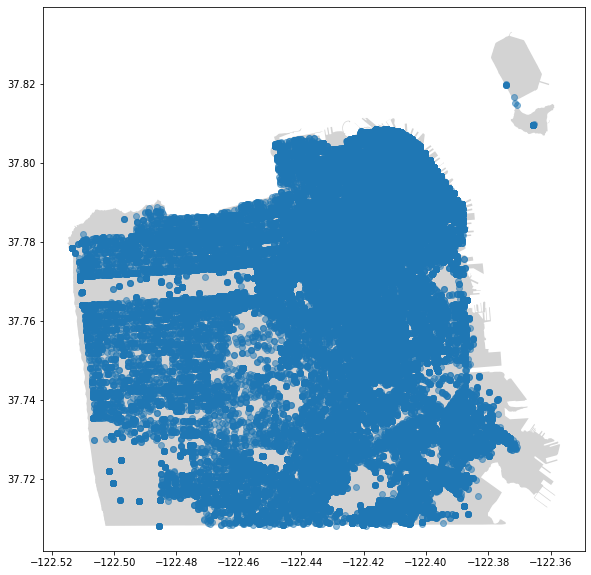

In [139]:
#把Sanfrancisco地圖跟散點圖疊起來,看分布狀況以及有沒有一些分布不合理的狀況
fig, ax = plt.subplots(figsize=(10,10))
# Plot the base map
SanfranciscoMap.plot(ax=ax, color='lightgrey', zorder=1)
# Overlay the data locations
geo_df.plot(ax=ax, alpha=0.5, zorder=2)
#看起來右上角極為密集。目前看起來分布尚屬合理,並沒有點分布在怪異的經緯度上

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


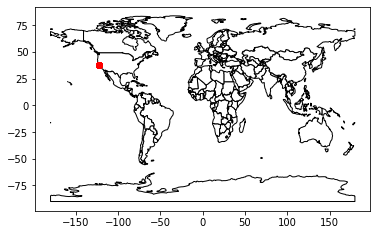

In [140]:
#利用世界地圖再確認一下分布狀況
def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(
        gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
    return gdf

train_gdf = create_gdf(train)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

In [141]:
#特徵工程:將經緯度資料做聚類降低值域

In [142]:
train_loc = train[["X","Y"]].reset_index(drop=True)
test_loc = test[["X","Y"]].reset_index(drop=True)
merge_loc = pd.concat([train_loc,test_loc]).reset_index(drop=True)

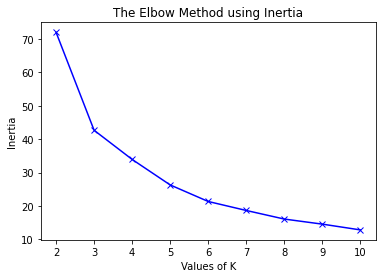

In [ ]:
#使用Elbow法去看一下聚類適合數量
K_clusters = range(2,11)
inertias = []
for i in K_clusters:
  kmeans_fit = KMeans(n_clusters=i).fit(train_loc)
  inertias.append(kmeans_fit.inertia_)

plt.plot(K_clusters, inertias, "bx-")
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

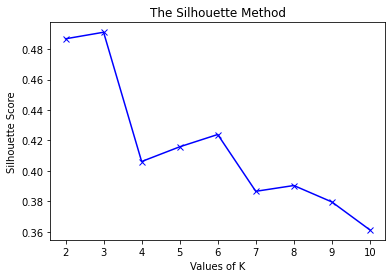

In [ ]:
#使用剪影法去跟Elbow法對比看最適合聚類數量
train_loc = train[["X","Y"]].reset_index(drop=True)
silhouette_avg = []
for i in K_clusters:
    kmeans_fit = KMeans(n_clusters=i).fit(train_loc)
    silhouette_avg.append(silhouette_score(train_loc, kmeans_fit.labels_))

plt.plot(K_clusters, silhouette_avg, "bx-")
plt.xlabel("Values of K")
plt.ylabel("Silhouette Score")
plt.title("The Silhouette Method")
plt.show()
#綜合Elbow跟剪影法,看起來聚類群數三為最適合

In [143]:
#使用KMeans聚類並把聚類結果當成新特徵加到train及test資料中
kmeans = KMeans(n_clusters=3, init ='k-means++').fit(merge_loc)
result = kmeans.predict(merge_loc) 
merge_loc["Area"] = pd.Series(result)

train["Area"] = result[:len(train)]
test["Area"] = result[len(train):]
train = train.drop(columns=["geometry"])

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


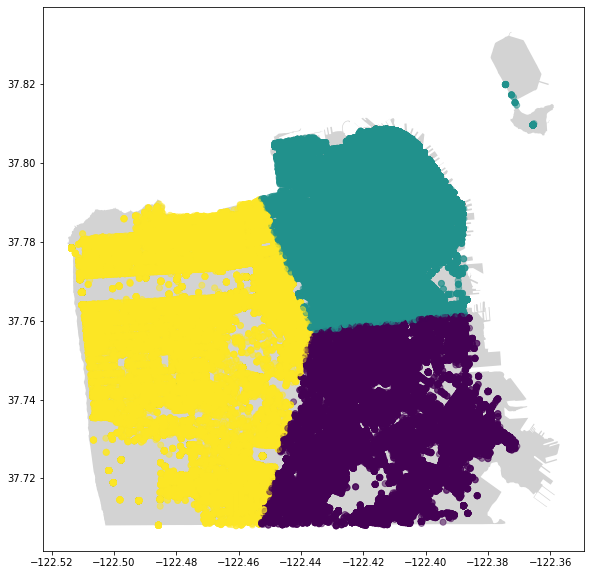

In [144]:
# 查看聚類成果
def plot(df):
  loc_geom = [Point(round(x,7),round(y,7)) for x,y in zip(df["X"], df["Y"])]
  loc_crs = {'init': 'epsg:4326'}
  geo_df = gpd.GeoDataFrame(df, crs=loc_crs, geometry=loc_geom)

  
  fig, ax = plt.subplots(figsize=(10,10))
  # Plot the base map
  SanfranciscoMap.plot(ax=ax, color='lightgrey', zorder=1)
  # Overlay the data locations
  geo_df.plot(column="Area",ax=ax, alpha=0.5, zorder=2)
  
plot(merge_loc)

In [145]:
#對地址進行處理:把含有Bolck的地址抓出來
train["Block"] = train["Address"].str.contains("Block", case=False, na=False)
test["Block"] = test["Address"].str.contains("Block", case=False, na=False)
train["Block"] = train["Block"].map(lambda x:1 if x == True else 0)
test["Block"] = test["Block"].map(lambda x:1 if x == True else 0)

In [146]:
#把不用的特徵丟棄
Id = test["Id"]
train = train.drop(columns=["Dates","Descript","Address","X","Y","YearOfMonth","Season","DayRange","HourRange"])
test = test.drop(columns=["Dates","Address","X","Y","YearOfMonth","Season","DayRange","HourRange","Id"])


In [147]:
#把Category,DayOfWeek,PdDistrict,Year用Label Encoding方式轉換
le = preprocessing.LabelEncoder()
train[["Category","DayOfWeek","PdDistrict","Year"]] = train[["Category","DayOfWeek","PdDistrict","Year"]].apply(le.fit_transform)
test[["DayOfWeek","PdDistrict","Year"]] = test[["DayOfWeek","PdDistrict","Year"]].apply(le.fit_transform)

In [148]:
#把最終的label及train切出來
label = train["Category"]
train = train.drop(columns=["Category"])

In [149]:
#訓練模型
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.3, random_state=42)

In [ ]:
#GaussianNB
gnb = GaussianNB()
gnb.fit(x_train, y_train)
gnb_predict = gnb.predict(x_test)
print("Accurancy of Model", accuracy_score(y_test, gnb_predict))

Accurancy of Model 0.19593747939062192


In [ ]:
#KNN
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn_predict = knn.predict(x_test)
print("Accurancy of Model", accuracy_score(y_test, knn_predict))

Accurancy of Model 0.20609378091406713


In [ ]:
#tree
tree = tree.DecisionTreeClassifier()
tree.fit(x_train, y_train)
tree_predict = tree.predict(x_test)
print("Accurancy of Model", accuracy_score(y_test, tree_predict))

Accurancy of Model 0.20596188089428213


In [ ]:
#Random Forest
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_predict = rf.predict(x_test)
print("Accuracy of Model", accuracy_score(y_test, rf_predict))

Accuracy of Model 0.22963793444569017


In [ ]:
#LGBM
lgbm = LGBMClassifier()
lgbm.fit(x_train, y_train)
lgbm_predict = lgbm.predict(x_test)
print("Accurancy of Model", accuracy_score(y_test, lgbm_predict))

Accurancy of Model 0.23827738574160787


In [152]:
#XGBoost
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
xgb_predict = xgb.predict(x_test)
print("Accuracy of Model::", accuracy_score(y_test, xgb_predict))

Accuracy of Model:: 0.2852008177801227


In [ ]:
#CatBoost
cat = CatBoostClassifier(silent=True)
cat.fit(x_train, y_train)
cat_predict = cat.predict(x_test)
print("Accuracy of Model", accuracy_score(y_test, cat_predict))

Accuracy of Model 0.2805513420827013


In [153]:
#綜合看下來xgb效果最好,因此保存此模型
modelName = "xgb_model"
pickle.dump(xgb, open(modelName, "wb"))

In [154]:
# 存取模型
xgb = pickle.load(open(modelName, "rb"))

In [158]:
#將結果做成csv檔案
# result = pd.Series(xgb.predict(test),name="Category")
submission = pd.concat([Id.reset_index(drop=True),result], axis=1)
submission

,Id,Category
0,0.0,1
1,1.0,21
2,2.0,16
3,3.0,34
4,4.0,34
...,...,...
143573,143573.0,16
143574,143574.0,16
143575,143575.0,16
143576,143576.0,21


In [159]:
#Submission改成Kaggle所指定格式
df = pd.get_dummies(submission["Category"])
le = preprocessing.LabelEncoder()
train = pd.read_csv("train.csv")
category = train["Category"].unique()
categoryLabel = le.fit_transform(train["Category"].unique())
Dict = {}
for i,j in zip(categoryLabel,category):
  Dict[i] = j
df = df.rename(columns=Dict)
dfColumn = df.columns.tolist()
diff = list(set(category.tolist())-set(dfColumn))
for column in diff:
  df[column] = 0
df = pd.concat([submission["Id"], df], axis=1)
submission = df
submission
submission.to_csv("Submission")